## <font  color='red'>Contents</font>

* [introduction](#1)

* [Loading required packages](#2)

* [Load Data](#3) 

    * [Cleaning function]()
    
* [Exploratory Data analysis](#4)

    * [Class distribution]()
    * [Distribution of length of tweets]()
    * [Distribution of number of words in tweets]()
    * [Distribution of target]()
    * [Common Stopwords]()
    * [Common words in tweets w/o stopwords]()
    * [Common bigrams in tweeets]()
    * [WordClouds of tweets]()
    * [Readability index]()
    
* [Hints for post-processing](#5)

    * [analyzing jaccard similarity]()





## <font  color='green'>Introduction</font><a id='1'></a>

With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or devastate profit because it strikes a negative tone. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds. But, which words actually lead to the sentiment description? In this competition you will need to pick out the part of the tweet (word or phrase) that reflects the sentiment.

Help build your skills in this important area with this broad dataset of tweets. Work on your technique to grab a top spot in this competition. What words in tweets support a positive, negative, or neutral sentiment?
![](https://media.giphy.com/media/xUPGcEOEllmvFAvako/giphy.gif)

## <font  color='green'>Loading Required packages</font><a id='2'></a>


In [1]:
!pip install textstat

     |████████████████████████████████| 99 kB 743 kB/s 
     |████████████████████████████████| 2.0 MB 3.0 MB/s 


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from collections import defaultdict,Counter
from wordcloud import WordCloud, STOPWORDS
from plotly.subplots import make_subplots
from nltk.tokenize import word_tokenize
import plotly.figure_factory as ff
from nltk.corpus import stopwords
import plotly.graph_objects as go
from textblob import TextBlob
import matplotlib.pyplot as plt
from nltk.util import ngrams
import plotly.offline as py
import plotly.express as px
from statistics import *
from plotly import tools
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
import textstat
import string
import json
import nltk
import gc
plt.style.use('seaborn')



In [3]:
py.init_notebook_mode(connected=True)
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## <font  color='green'>Load Data</font><a id='3'></a>

In [4]:
train=pd.read_csv("../input/tweet-sentiment-extraction/train.csv")
test=pd.read_csv("../input/tweet-sentiment-extraction/test.csv")
target=train['sentiment']

In [5]:
print('There are {} rows and {} cols in train set'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} cols in test set'.format(test.shape[0],test.shape[1]))

There are 27481 rows and 4 cols in train set
There are 3534 rows and 3 cols in test set


In [6]:
print(train.dtypes)
train

textID           object
text             object
selected_text    object
sentiment        object
dtype: object


textID                                               text  \
0      cb774db0d1                I`d have responded, if I were going   
1      549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2      088c60f138                          my boss is bullying me...   
3      9642c003ef                     what interview! leave me alone   
4      358bd9e861   Sons of ****, why couldn`t they put them on t...   
...           ...                                                ...   
27476  4eac33d1c0   wish we could come see u on Denver  husband l...   
27477  4f4c4fc327   I`ve wondered about rake to.  The client has ...   
27478  f67aae2310   Yay good for both of you. Enjoy the break - y...   
27479  ed167662a5                         But it was worth it  ****.   
27480  6f7127d9d7     All this flirting going on - The ATG smiles...   

                                           selected_text sentiment  
0                    I`d have responded, if I were going   neutral  
1                                               Sooo SAD  negative  
2                                            bullying me  negative  
3                                         leave me alone  negative  
4                                          Sons of ****,  negative  
...                                                  ...       ...  
27476                                             d lost  negative  
27477                                      , don`t force  negative  
27478                          Yay good for both of you.  positive  
27479                         But it was worth it  ****.  positive  
27480  All this flirting going on - The ATG smiles. Y...   neutral  

[27481 rows x 4 columns]

### <font size='3' color='blue'> Cleaning function</font>


In [7]:
import re
def basic_cleaning(text):
    text=re.sub(r'https?://www\.\S+\.com','',text)
    text=re.sub(r'[^A-Za-z|\s]','',text)
    return text

def clean(df):
    for col in ['text','selected_text']:
        df[col]=df[col].astype(str).apply(lambda x:basic_cleaning(x))
    return df


sent=train.sentiment.unique()

## <font color='green'>Exploratory Data Analysis</font><a id='4'></a>

### <font size='3' color='blue'> Class distribution of sentiment label</font>


In [8]:
fig=make_subplots(1,2,subplot_titles=('Train set','Test set'))
x=train.sentiment.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['blue','green','red'],name='train'),row=1,col=1)
x=test.sentiment.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['blue','green','red'],name='test'),row=1,col=2)
fig.update_layout(showlegend=False)
fig.show()
colors = ['blue','green','red']

- There is a very mild class imbalance between labels, neutral class sligtly dominates over the other class tweets. This makes sense because if the sentiment is calculated in numerical scale, it would roughly follow normal distribution.
- The distributions of labels has no significant difference between train and test.

**But our task is not to predict these labels,but to predict the selected text which can help us figure out the sentiment**

In [9]:
df=pd.concat([train,test], sort=False)
df['text']=df['text'].astype(str)
df['selected_text']=df['selected_text'].astype(str)


### <font size='3' color='blue'>What's the distribution of length of tweet?</font>

In [10]:
vals=[]
for i in range(0,3):
    x=df[df['sentiment']==sent[i]]['text'].str.len()
    vals.append(x)

In [11]:
fig = ff.create_distplot(vals, sent,show_hist=False, colors=colors)
fig.update_layout(title="Distribution of number of characters in tweets")
fig.show()

- The number of character in tweets ranges from 1 to 140 (max).
- The distribution is roughly uniform and no significant difference among three sentiment classes.


### <font size='3' color='blue'>What is the distribution of selected text?</font>

In [12]:
vals=[]
for i in range(0,3):
    x=df[df['sentiment']==sent[i]]['selected_text'].dropna().str.len()
    vals.append(x)

In [13]:
fig = ff.create_distplot(vals, sent, show_hist=False, colors=colors)
fig.update_layout(title="Distribution of number of characters in selected text")
fig.show()

- The selected text is of much larger length in neutral sentiment tweets. We will see later this is due to the fact that neutral sentiment 'has to' select entire tweets to justify it is neural.
- The distribution of selected_text in positive and negative are similar.

### <font size='3' color='blue'>What is the distribution of Number of words in a tweet?</font>

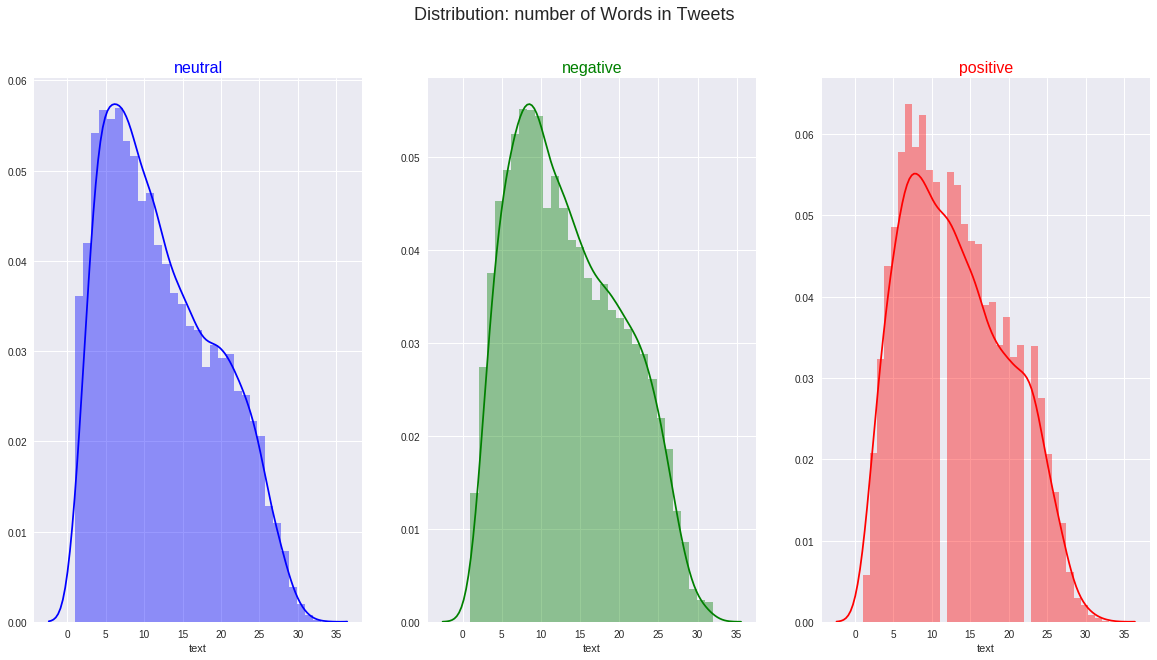

In [14]:
df['punc']=df['text'].apply(lambda x : [c for c in x if c in string.punctuation])
fig,ax=plt.subplots(1,3,figsize=(20,10))
for i in range(3):
    new=df[df['sentiment']==sent[i]]['text'].str.split().str.len()
    sns.distplot(new,color=colors[i],ax=ax[i])
    ax[i].set_title(sent[i],color=colors[i], fontsize=16)
    
fig.suptitle("Distribution: number of Words in Tweets", fontsize=18) 
fig.show()

- The number of words in tweets ranges from 1 to 30.

### <font size='3' color='blue'>What is distribution of number of words in selected text?</font>

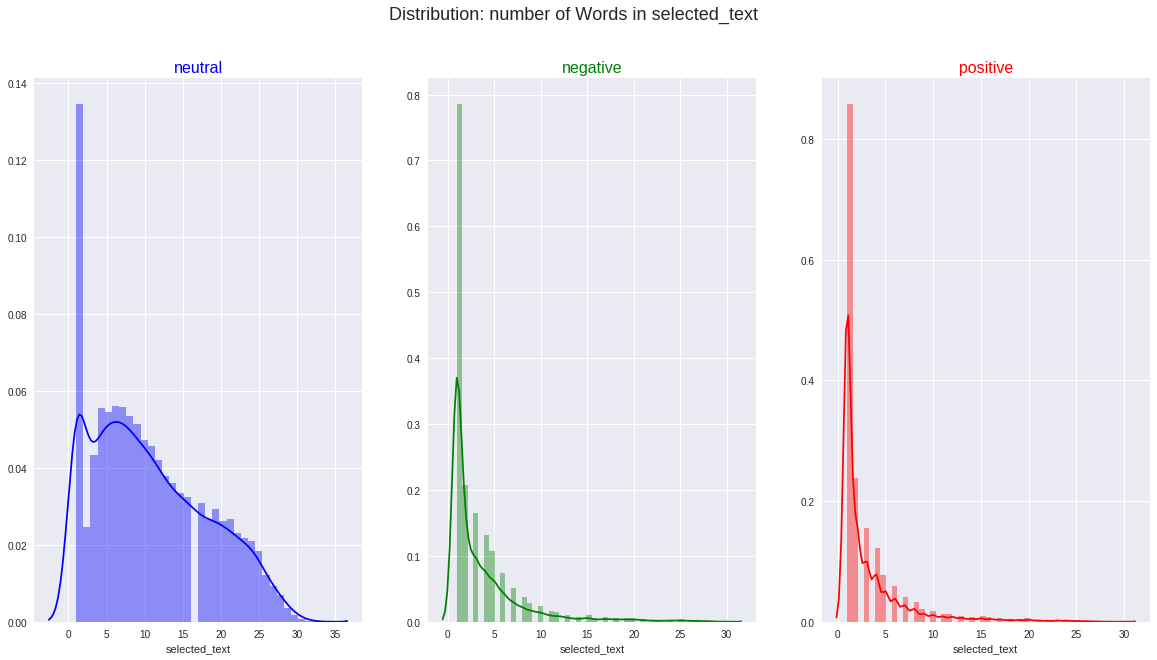

In [15]:
df['punc']=df['text'].apply(lambda x : [c for c in x if c in string.punctuation])
fig,ax=plt.subplots(1,3,figsize=(20,10))
for i in range(3):
    new=df[df['sentiment']==sent[i]]['selected_text'].str.split().str.len()
    sns.distplot(new,color=colors[i],ax=ax[i])
    ax[i].set_title(sent[i],color=colors[i], fontsize=16)
    
fig.suptitle("Distribution: number of Words in selected_text", fontsize=18) 
fig.show()

### <font size='3' color='blue'>Which are the most common stopwords?</font>

In [16]:
def preprocess_news(df,stop=stop,n=1,col='text'):
    '''Function to preprocess and create corpus'''
    new_corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for text in df[col]:
        words=[w for w in word_tokenize(text) if (w not in stop)]
       
        words=[lem.lemmatize(w) for w in words if(len(w)>n)]
     
        new_corpus.append(words)
        
    new_corpus=[word for l in new_corpus for word in l]
    return new_corpus


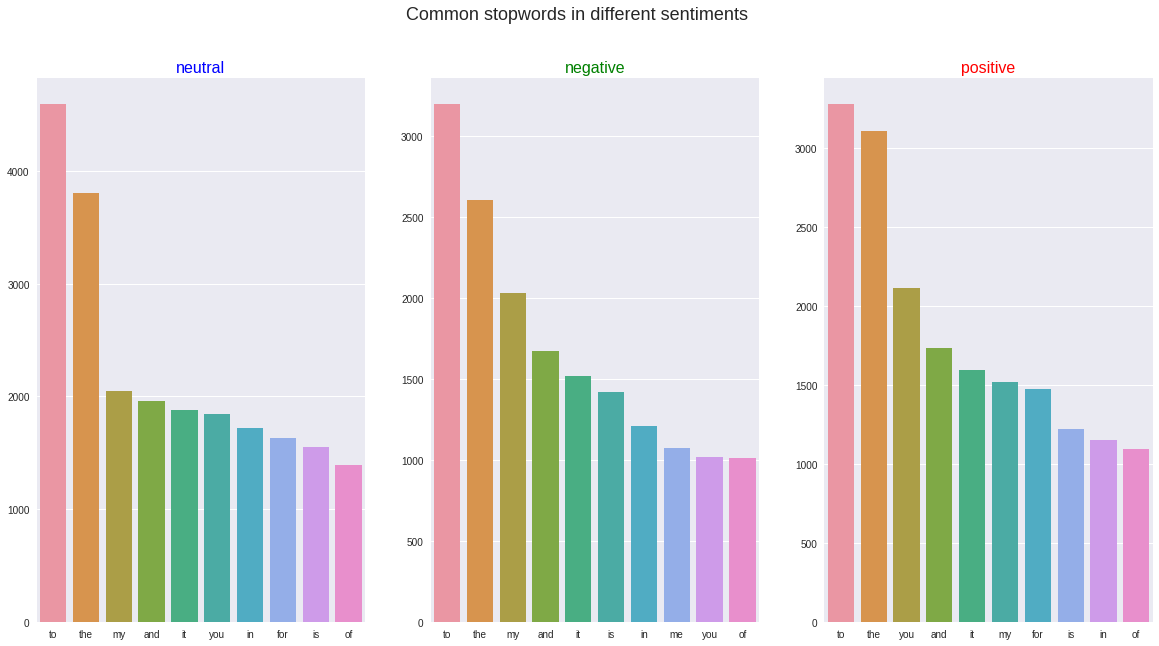

In [17]:

fig,ax=plt.subplots(1,3,figsize=(20,10))
for i in range(3):
    new = df[df['sentiment']==sent[i]][['text']]
    corpus_train=preprocess_news(new,{})
    
    dic=defaultdict(int)
    for word in corpus_train:
        if word  in stop:
            dic[word]+=1
            
    top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y = zip(*top)  # zip(*) is unzipping a list
    x, y = list(x), list(y)
    sns.barplot(x,y,ax=ax[i])
    #ax[i].bar(x,y,color=colors[i])
    ax[i].set_title(sent[i], color=colors[i],fontsize=16)

fig.suptitle("Common stopwords in different sentiments", fontsize=18)
fig.show()

### <font size='3' color='blue'>Distribution: punctuations in tweets</font>

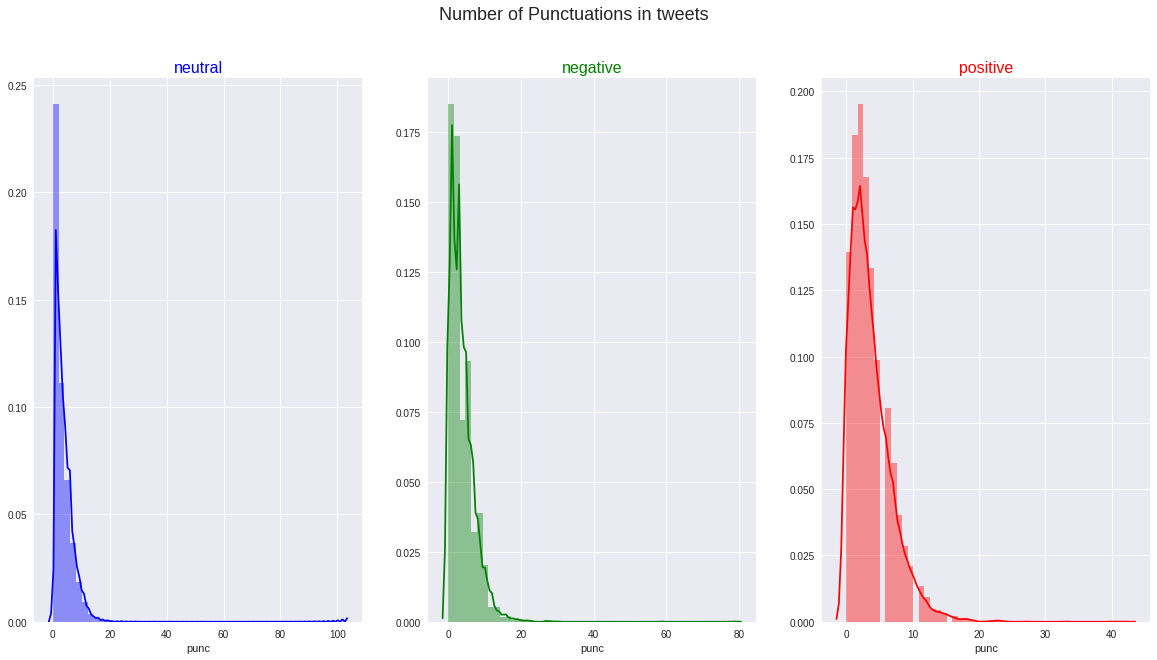

In [18]:
df['punc']=df['text'].apply(lambda x : [c for c in x if c in string.punctuation])
fig,ax=plt.subplots(1,3,figsize=(20,10))
for i in range(3):
    new=df[df['sentiment']==sent[i]]['punc'].map(lambda x: len(x))
    sns.distplot(new,color=colors[i],ax=ax[i])
    ax[i].set_title(sent[i],color=colors[i], fontsize=16)
    
fig.suptitle("Number of Punctuations in tweets", fontsize=18) 
fig.show()

- There is no significant difference

### <font size='3' color='blue'>Number of unique words in tweets</font>

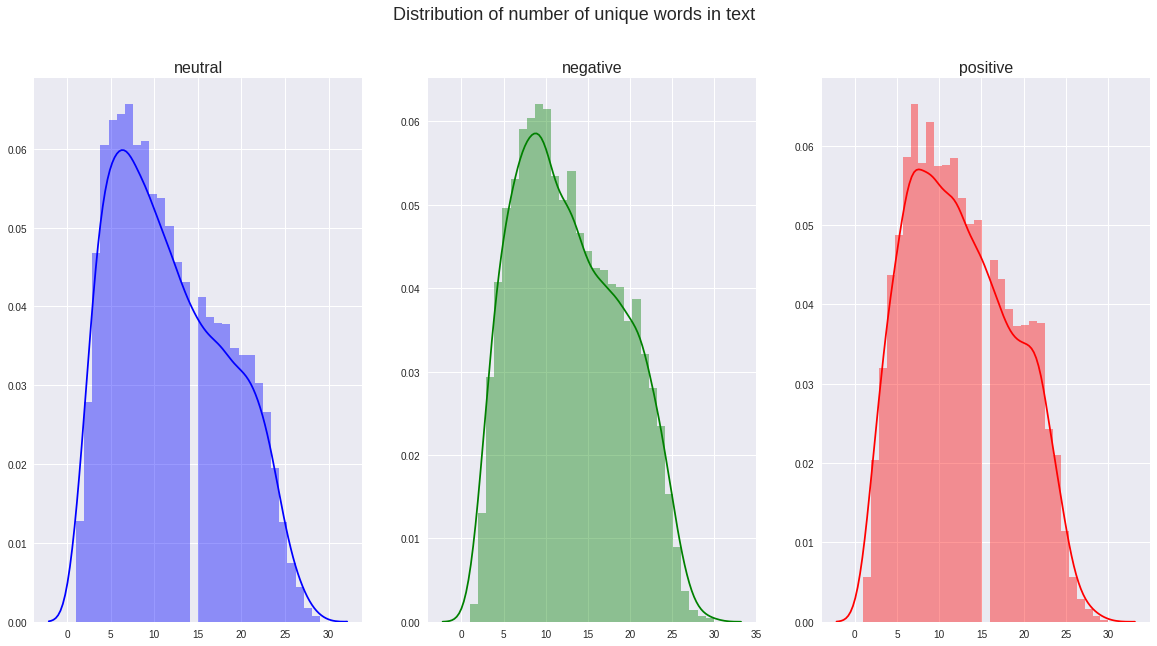

In [19]:
fig,ax=plt.subplots(1,3,figsize=(20,10))
for i in range(3):
    new=df[df['sentiment']==sent[i]]['text'].map(lambda x: len(set(x.split())))
    sns.distplot(new.values,ax=ax[i],color=colors[i])
    ax[i].set_title(sent[i], fontsize=16)
fig.suptitle("Distribution of number of unique words in text", fontsize=18)
fig.show()

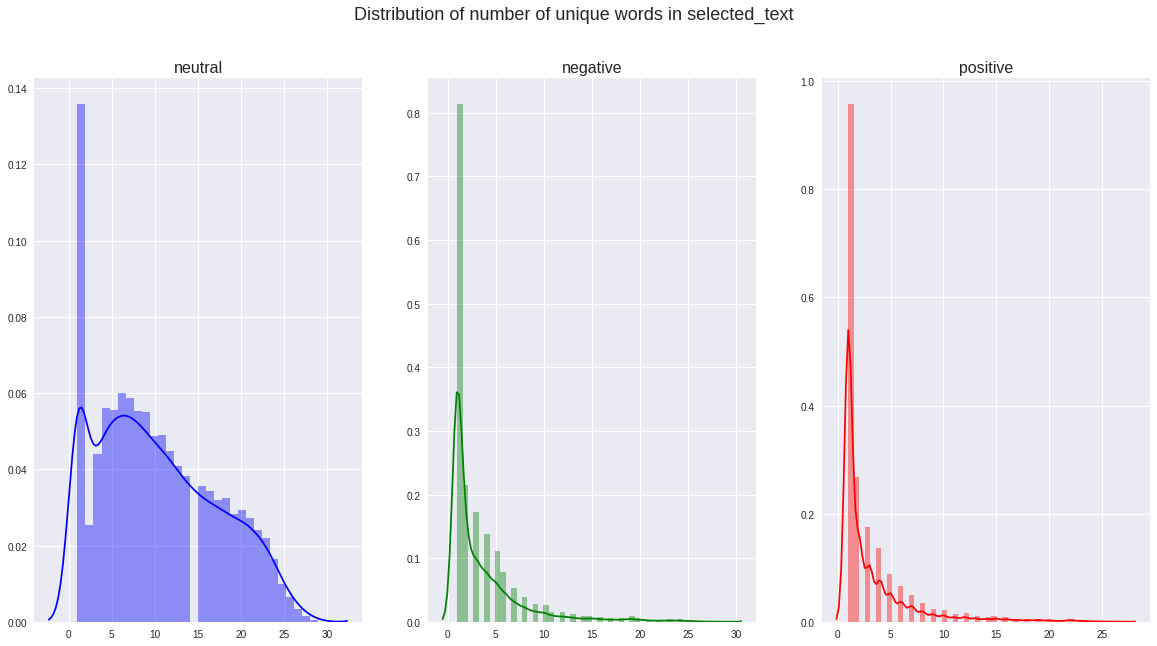

In [20]:
fig,ax=plt.subplots(1,3,figsize=(20,10))
for i in range(3):
    new=df[df['sentiment']==sent[i]]['selected_text'].astype(str).map(lambda x: len(set(x.split())))
    sns.distplot(new.values,ax=ax[i],color=colors[i])
    ax[i].set_title(sent[i], fontsize=16)
fig.suptitle("Distribution of number of unique words in selected_text", fontsize=18)
fig.show()

- For negative and positive tweets this distributions is similar,this should be because of selected keywords from tweets.
- In case of neutral tweets it is spread and there aren't a specefic keyword to select.
- This may cause neutral class to be difficult to predict.

### <font size='3' color='blue'>Common punctuations in tweets</font>

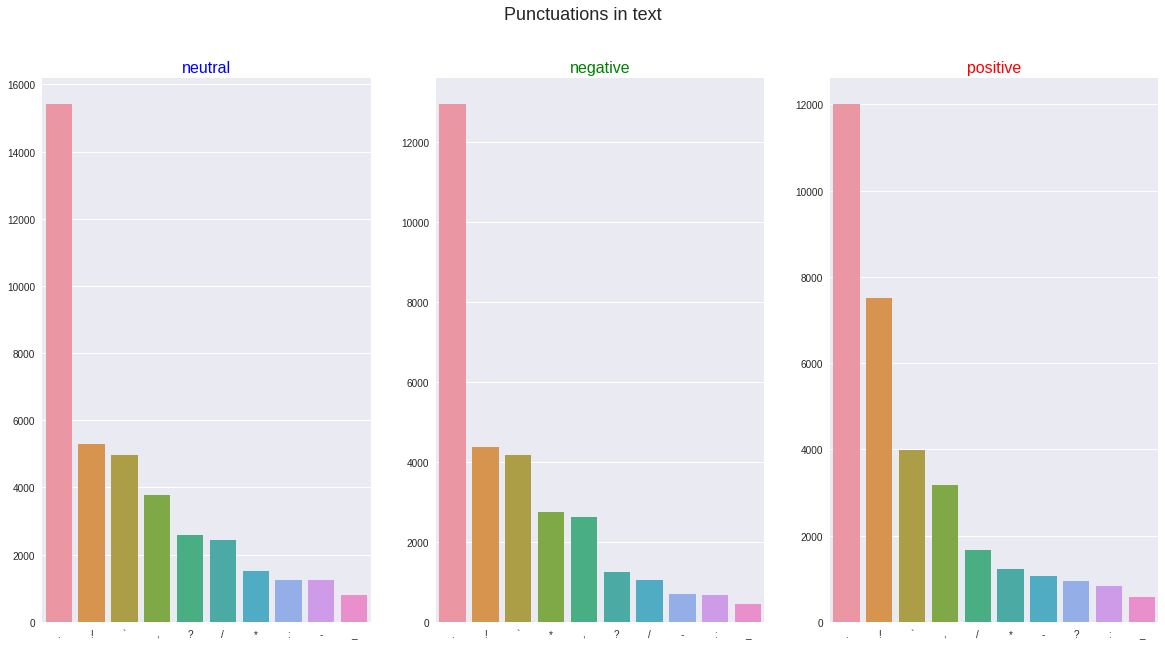

In [21]:
fig,ax=plt.subplots(1,3,figsize=(20,10))
for i in range(3):
    new=df[df['sentiment']==sent[i]]['punc']
    punc=[p for pun in new.values for p in pun]
    counter=Counter(punc).most_common(10)
    x,y=zip(*counter)
    x, y = list(x), list(y)
    sns.barplot(x,y,ax=ax[i])
    #ax[i].bar(x,y,color=colors[i])
    ax[i].set_title(sent[i], color=colors[i],fontsize=16)
    
fig.suptitle("Punctuations in text",fontsize=18) 
fig.show()
    
    

## <font size='4' color='blue'>Which are the most common words?</font> 

In [22]:
# clean use re
df=clean(df)

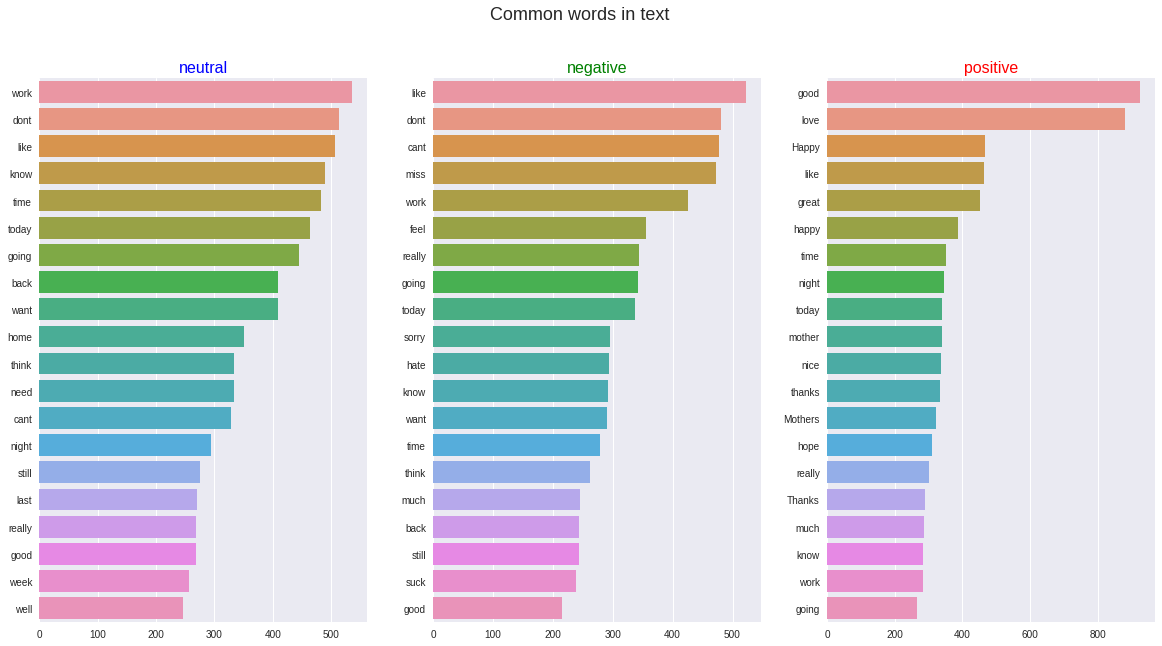

In [23]:

fig,ax=plt.subplots(1,3,figsize=(20,10))
for i in range(3):
    new=df[df['sentiment']==sent[i]]
    corpus_train=preprocess_news(new,n=3)
    counter=Counter(corpus_train)
    most=counter.most_common()
    x, y = zip(*most[:20])
    sns.barplot(list(y),list(x),ax=ax[i])
    ax[i].set_title(sent[i],color=colors[i],fontsize=16)
fig.suptitle("Common words in text",fontsize=18)
fig.show()

- It is very different at this time since words represent sentiment appear most often.

## <font color='blue' size='4'>Which are the most common words in selected text?</font>

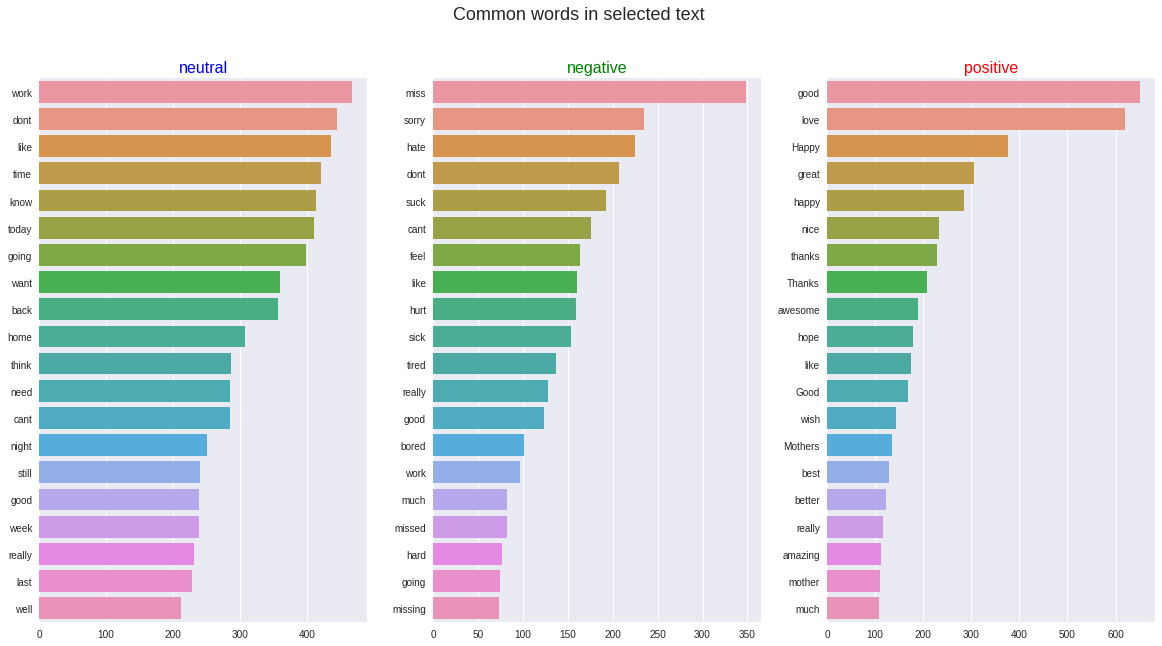

In [24]:
fig,ax=plt.subplots(1,3,figsize=(20,10))
for i in range(3):
    new=df[df['sentiment']==sent[i]]   
    corpus=preprocess_news(new,n=3,col='selected_text')
    counter=Counter(corpus)
    most=counter.most_common()
    x, y = zip(*most[:20])
    sns.barplot(list(y),list(x),ax=ax[i])
    ax[i].set_title(sent[i],color=colors[i],fontsize=16)
fig.suptitle("Common words in selected text",fontsize=18)
fig.show()

- frequent words greatly differs again in selected_text


### <font size='3' color='blue'>Check for bigrams in selected text</font>

In [25]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n),stop_words=stop).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

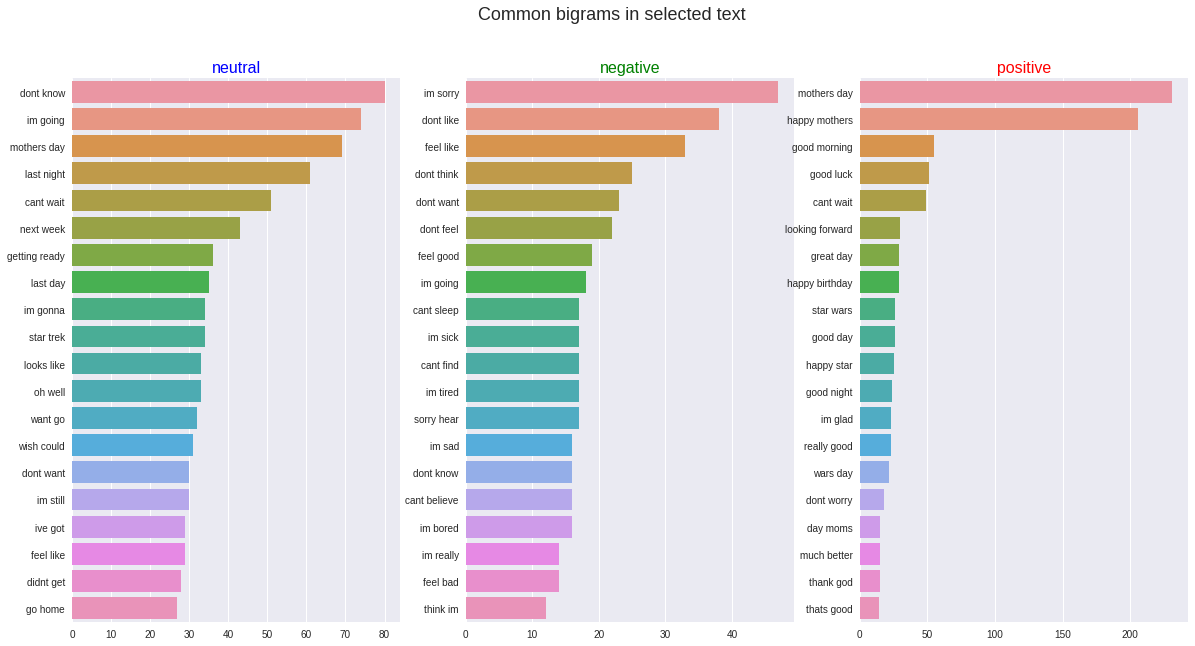

In [26]:
fig,ax=plt.subplots(1,3,figsize=(20,10))
for i in range(3):
    new=df[df['sentiment']==sent[i]]['selected_text']
    top_n_bigrams=get_top_ngram(new,2)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(list(y),list(x),ax=ax[i])
    ax[i].set_title(sent[i],color=colors[i],fontsize=16)
    
fig.suptitle("Common bigrams in selected text",fontsize=18)
fig.show()

- `'positve` tweets are filled with positive words like `great day`,'`happy day` etc.
- `negative` tweets have bigrams like `im sorry`, and many words starting with `dont`.

### <font size='3' color='blue'>WordCloud for tweets</font>

In [27]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None,ax=None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1 
        )
    
    wordcloud=wordcloud.generate(str(data))
    ax.imshow(wordcloud,interpolation='nearest')
    ax.axis('off')
    

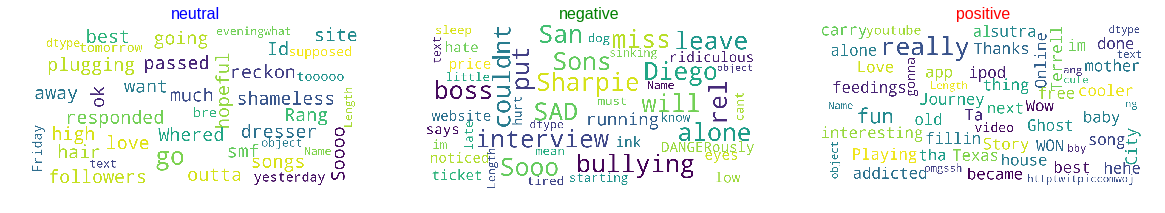

In [28]:
fig,ax=plt.subplots(1,3,figsize=(20,10))
for i in range(3):
    new=df[df['sentiment']==sent[i]]['text']
    show_wordcloud(new,ax=ax[i])
    ax[i].set_title(sent[i],color=colors[i],fontsize=16)
plt.show()

### <font size='3' color='blue'>Wordcloud for selected text</font>

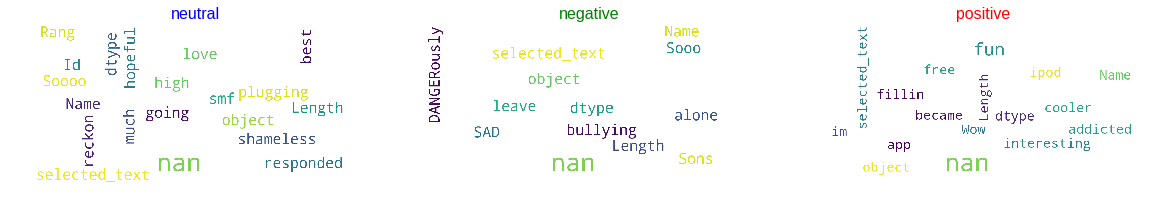

In [29]:
fig,ax=plt.subplots(1,3,figsize=(20,12))
for i in range(3):
    new=df[df['sentiment']==sent[i]]['selected_text'].dropna()
    show_wordcloud(new,ax=ax[i])
    ax[i].set_title(sent[i],color=colors[i],fontsize=16)
plt.show()
    

### <font size = '3'  color='green' >Readability features</font>

Readability is the ease with which a reader can understand a written text. In natural language processing, the readability of text depends on its content. It focuses on the words we choose, and how we put them into sentences and paragraphs for the readers to comprehend.
9.1 The Flesch Reading Ease formula

   - In the Flesch reading-ease test, higher scores indicate material that is easier to read; lower numbers mark passages that are more difficult to read. The formula for the Flesch reading-ease score (FRES) test is 
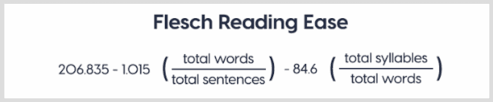   
   
   
   
  -  90-100 - Very Easy
  -  80-89 - Easy
  -  70-79 - Fairly Easy
  -  60-69 - Standard
  -  50-59 - Fairly Difficult
  -  30-49 - Difficult
  -  0-29 - Very Confusing


In [30]:
#utility functions:
def plot_readability(a,b,c,title,bins=0.4,colors=colors):
    trace1 = ff.create_distplot([a,b,c],sent, bin_size=bins, colors=colors, show_rug=False)
    trace1['layout'].update(title=title)
    py.iplot(trace1, filename='Distplot')
    table_data= [["Statistical Measures","neu",'pos','neg'],
                ["Mean",mean(a),mean(b),mean(c)],
                ["Standard Deviation",pstdev(a),pstdev(b),pstdev(c)],
                ["Variance",pvariance(a),pvariance(b),pvariance(c)],
                ["Median",median(a),median(b),median(c)],
                ["Maximum value",max(a),max(b),max(c)],
                ["Minimum value",min(a),min(b),min(c)]]
    trace2 = ff.create_table(table_data)
    py.iplot(trace2, filename='Table')


In [31]:
tqdm.pandas()
fre_neu = np.array(df["text"][df["sentiment"] == sent[0]].progress_apply(textstat.flesch_reading_ease))
fre_pos = np.array(df["text"][df["sentiment"] == sent[1]].progress_apply(textstat.flesch_reading_ease))
fre_neg = np.array(df["text"][df["sentiment"] == sent[2]].progress_apply(textstat.flesch_reading_ease))

plot_readability(fre_neu,fre_pos,fre_neg,"Flesch Reading Ease",20)

100%|██████████| 9685/9685 [00:00<00:00, 13111.78it/s]


- Mean score of tweets is ~70,so it is considered as fairly easy to read.

## <font  color='red'>Hints for post processing</font><a id='5'></a>

In [32]:
def jaccard(str1, str2): 
    a = set(str(str1).lower().split()) 
    b = set(str(str2).lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


In [33]:
def plot_jaccard(sentiment,color,ax):
    jacc=[]
    text=train[train['sentiment']==sentiment].dropna()['text'].values.tolist()
    selected=train[train['sentiment']==sentiment].dropna()['selected_text'].values.tolist()
    for i,k in zip(text,selected):
        jacc.append(jaccard(i,k))
    ax.hist(jacc,bins=10,color=color,alpha=0.4)
    ax.set_title(sentiment,fontsize=16)
    

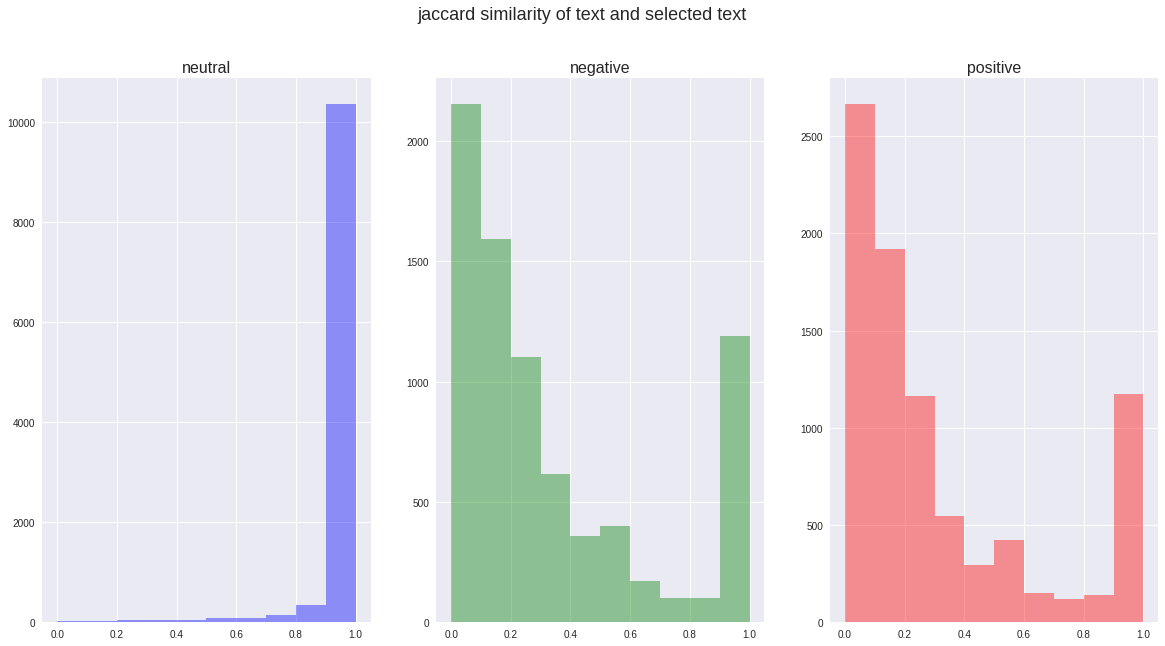

In [34]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,10))
plot_jaccard('neutral','blue',ax1)
plot_jaccard('negative','green',ax2)
plot_jaccard('positive','red',ax3)

fig.suptitle('jaccard similarity of text and selected text',fontsize=18)
plt.show()

- here we can easily observe that the jaccard similarity of most of samples with neutral sentiment is close to 1. **In most neutral cases, most of the selected_text is the entire text**
- Also there are some examples in positive and negative tweets with similarity of 1 (entire text).

In [35]:
train['jaccard']=train.apply(lambda x : jaccard(x.text,x.selected_text),axis=1)
positive=train[(train['sentiment']=='positive') & (train['jaccard']>0.9)]
positive.head()

textID                                               text  \
25  e00c6ef376  the free fillin` app on my ipod is fun, im add...   
54  d8ba2a99a9                              romance zero is funny   
68  fa2654e730                                           Chilliin   
80  bbbc46889b                    THANK YYYYYYYYYOOOOOOOOOOUUUUU!   
85  3d2fcd78c8  Happy Star Wars day everyone! and Enjoy the ho...   

                                        selected_text sentiment  jaccard  
25  the free fillin` app on my ipod is fun, im add...  positive      1.0  
54                              romance zero is funny  positive      1.0  
68                                           Chilliin  positive      1.0  
80                    THANK YYYYYYYYYOOOOOOOOOOUUUUU!  positive      1.0  
85  Happy Star Wars day everyone! and Enjoy the ho...  positive      1.0

- Are these examples in postive and negative classes related with text length?

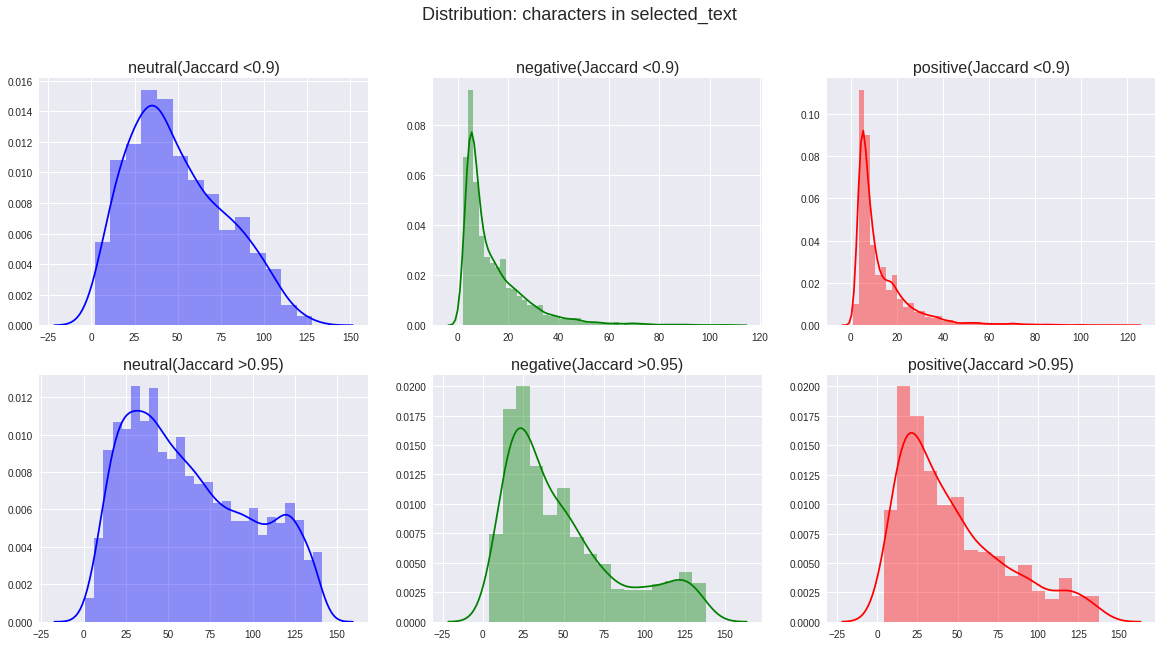

In [36]:

fig,ax=plt.subplots(2,3,figsize=(20,10))
condition = [(train['jaccard']<0.9), (train['jaccard']>0.95)]
titles = ['(Jaccard <0.9)', '(Jaccard >0.95)']
for i in range(2):
    for j in range(3):
        new=train[(train['sentiment']==sent[j]) & condition[i] ]['selected_text'].astype(str).str.len()
        sns.distplot(new.values,ax=ax[i,j],color=colors[j])
        ax[i,j].set_title(sent[j]+ titles[i], fontsize=16)
    fig.suptitle("Distribution: characters in selected_text", fontsize=18)
fig.show()

For positive and negative, we see when tweets gets longer, it is more likely to select the entire text.

### Check if sentiment matches with polarity of selected text to see if there is any errors.

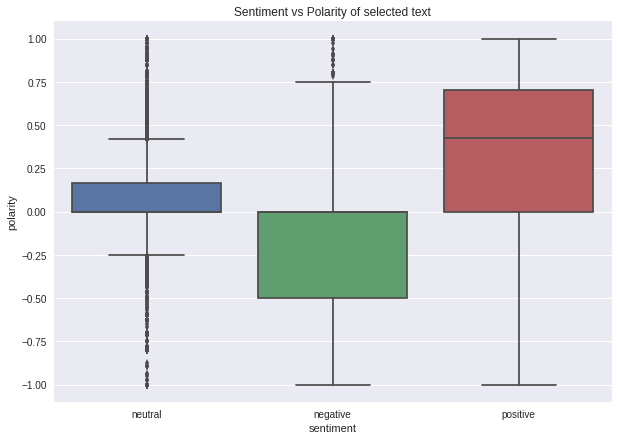

In [37]:
def get_sent(text):
    testimonial = TextBlob(str(text))
    return testimonial.sentiment.polarity

plt.figure(figsize=(10,7))
train['polarity']=train['selected_text'].apply(lambda x : get_sent(x))
sns.boxplot(x='sentiment', y='polarity', data=train)
plt.gca().set_title('Sentiment vs Polarity of selected text')
plt.show()



It matches well so the labelling quality is good, there is not systematic error.
let's check the correlation between the number of words in tweet and selected text


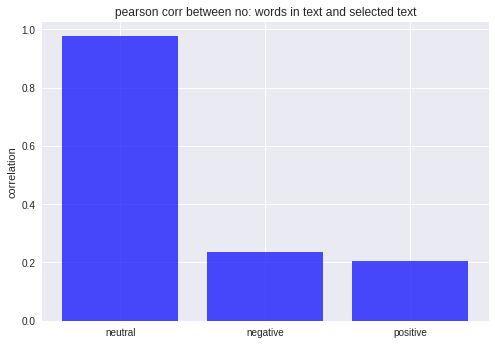

In [38]:
import scipy
corr=[]
for i in sent:
    text_pos=train[train['sentiment']==i]['text'].astype(str).map(lambda x : len(x.split()))
    sel_pos=train[train['sentiment']==i]['selected_text'].astype(str).map(lambda x : len(x.split()))
    corr.append(scipy.stats.pearsonr(text_pos,sel_pos)[0])
plt.bar(sent,corr,color='blue',alpha=.7)
plt.gca().set_title("pearson corr between no: words in text and selected text")
plt.gca().set_ylabel("correlation")
plt.show()